# pyslammer demo: batch simulations
This notebook shows an example use case of pyslammer for running batch simulations.

## Setup

Assumes pyslammer is installed in the current python environment. 
*Documentation on installation pending*

First, import pyslammer using:

```python
import pyslammer as slam
```

Additional Python libriaries, such as `matplotlib` may also be useful.

In [ ]:
# If running in Jupyterlite with Pyodide, install the additional packages
%pip install pyslammer
%pip install numpy
%pip install matplotlib
%pip install ipympl
%matplotlib widget

In [1]:
import pyslammer as slam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Input

Running an sliding block analysis with pySLAMMER requires at least two sets of input: 1) Slope parameters, and 2) a ground motion.

## Slope Parameters

For any analysis type, a yield acceleration, $k_y$, is needed. 
*IN DEVELOPMENT: If coupled or decoupled analysis is performed, additional inputs are required. For any analysis type, at least one value of $k_y$ is needed, but $k_y$ can also be a function of displacement.*


## Ground motion

TODO: expand

## Single simulation
Run a single rigid sliding block analysis and plot the output.
A Northridge earthquake recording and a yield acceleration of 0.2 g are used

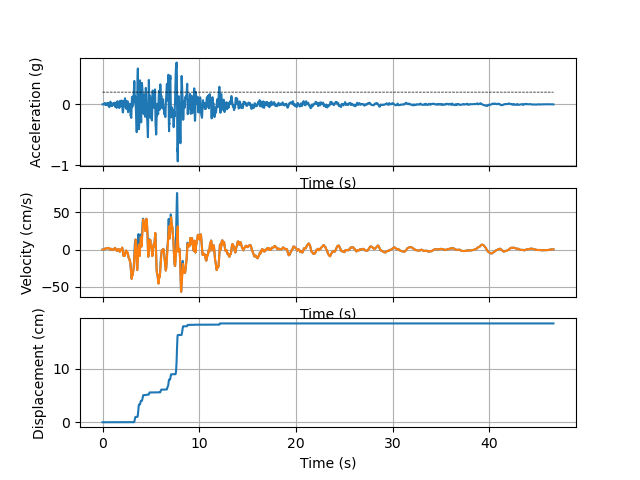

In [2]:
# single simulation
g = 9.81 # TODO: change code so that g is not needed when ky is given
ky = 0.2*g

tHist = slam.normModeTimeHist('../sample_ground_motions/Northridge_VSP-360.csv')
gAcc, gVel, bVel, bDisp, t = slam.downslopeAnalysis(tHist,ky)
plt.close('all')
fig, axs = slam.plotOutput(gAcc,gVel,bVel,bDisp,t,ky/g)
plt.show()

## Batch simulation
Eventually, this will be a more powerful demo with several parameter options. 
Currently, there's only one recorded ground motion pre-loaded and one analysis type (rigid). 
But soon, we'll have a small suite of recorded ground motions whose results can be easily compared.

In [3]:
# batch simulation
g = 9.81 # TODO: change code so that g is not needed when ky is given
kys = np.linspace(0.01,0.7,100)*g
tHist = slam.normModeTimeHist('../sample_ground_motions/Northridge_VSP-360.csv')

output = {}

for ky in kys:
    gAcc, gVel, bVel, bDisp, t = slam.downslopeAnalysis(tHist,ky)
    output[ky/g] = {"d_max": max(bDisp), "time":t, "disp": bDisp}

# convert the output to a pandas dataframe
df = pd.DataFrame.from_dict(output,orient='index')
df = df.reset_index()
df = df.rename(columns={df.columns[0]: "ky"})


One way way can plot these results is to look at the maximum displacement for each analysis by its yield acceleration:

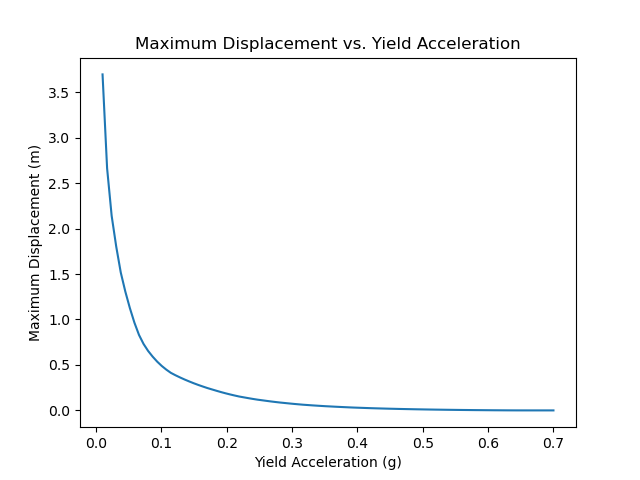

In [6]:
fig, ax = plt.subplots()
ax.plot(df["ky"],df["d_max"])
ax.set_xlabel('Yield Acceleration (g)')
ax.set_ylabel('Maximum Displacement (m)')
ax.set_title('Maximum Displacement vs. Yield Acceleration')
plt.show()

Because pyslammer returns the full displacement time history for each analysis, we can also plot the time histories for every analysis and color them by ky:

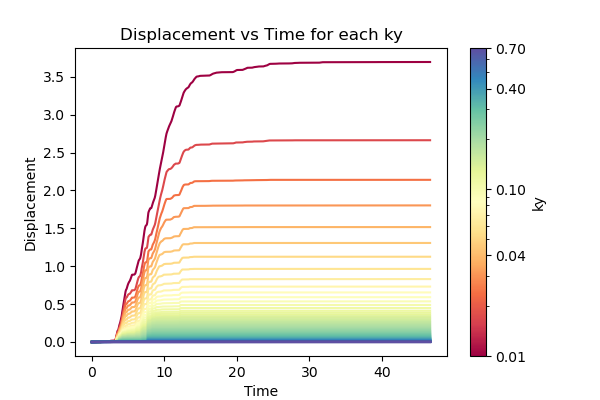

In [10]:

import matplotlib.cm as cm
from matplotlib.colors import LogNorm

# Create a figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Create a color map
cmap = plt.colormaps['Spectral']#cm.get_cmap('viridis')
norm = LogNorm(df['ky'].min(), df['ky'].max())

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    color = cmap(norm(row['ky']))
    ax.plot(row['time'], row['disp'], color=color)
    
# ax.set_yscale('log')
# ax.set_ylim([0.001,10])

# Add a color bar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# Add a color bar
cbar = fig.colorbar(sm, ax=ax, label='ky')

# Set the colorbar ticks and labels
ticks = [0.01, 0.04, 0.1, 0.4, 0.7]#np.linspace(df['ky'].min(), df['ky'].max(), num=5)  # Adjust num for more or fewer ticks
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.2f}' for tick in ticks])  # Adjust the format as needed

ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
ax.set_title('Displacement vs Time for each ky')
plt.show()